In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pandas scikit-image mahotas numpy opencv-python matplotlib
!pip install --upgrade scikit-image
!pip install opencv-python-headless numpy
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from skimage import io
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

RANDOM_SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load CSV and JSON data
#existing_images_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/existing_images.csv')

In [ ]:
"""

# Path to the folder containing images
images_folder = '/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/train_images'

# Initialize a dictionary to count labels with existing images
label_counts_with_images = {}

# Iterate through the dataframe and check if the image exists
for idx, row in df.iterrows():
    image_id = row['image_id']
    label = row['label']
    image_path = os.path.join(images_folder, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Count the label if the image exists
        if label not in label_counts_with_images:
            label_counts_with_images[label] = 1
        else:
            label_counts_with_images[label] += 1

# Convert the counts into a sorted format and print them
for label, count in sorted(label_counts_with_images.items()):
    print(f'Label: {label}, Count: {count}')

"""


"\n\n# Path to the folder containing images\nimages_folder = '/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/train_images'\n\n# Initialize a dictionary to count labels with existing images\nlabel_counts_with_images = {}\n\n# Iterate through the dataframe and check if the image exists\nfor idx, row in df.iterrows():\n    image_id = row['image_id']\n    label = row['label']\n    image_path = os.path.join(images_folder, image_id)\n\n    # Check if the image file exists\n    if os.path.exists(image_path):\n        # Count the label if the image exists\n        if label not in label_counts_with_images:\n            label_counts_with_images[label] = 1\n        else:\n            label_counts_with_images[label] += 1\n\n# Convert the counts into a sorted format and print them\nfor label, count in sorted(label_counts_with_images.items()):\n    print(f'Label: {label}, Count: {count}')\n\n"

In [ ]:
# Assuming 'label' is the column in your dataframe that contains the labels
#label_counts = existing_images_df['label'].value_counts()

#Print the counts for each label
#print(label_counts)

label
3    11027
4     2166
2     1993
1     1831
0      921
Name: count, dtype: int64


In [ ]:
#RANDOM_SEED = 42

#sample_size = 921

#balanced_dfs = []

#df_label_0 = existing_images_df[existing_images_df['label'] == 0]
#balanced_dfs.append(df_label_0)

#for label in [1, 2, 3, 4]:
#    df_label = existing_images_df[existing_images_df['label'] == label]
#
#    df_sampled = df_label.sample(n=sample_size, random_state=RANDOM_SEED)
#
#    balanced_dfs.append(df_sampled)

#balanced_df = pd.concat(balanced_dfs)

#balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

#print(balanced_df['label'].value_counts())

label
4    921
0    921
1    921
3    921
2    921
Name: count, dtype: int64


In [ ]:
#RANDOM_SEED = 42

#train_df, temp_df = train_test_split(
#    balanced_df,
#    test_size=0.2,
#    random_state=RANDOM_SEED,
#    stratify=balanced_df['label']
#)
#validate_df, test_df = train_test_split(
#    temp_df,
#    test_size=0.5,
#    random_state=RANDOM_SEED,
#    stratify=temp_df['label']
#)

#print(f'Train set size: {len(train_df)}')
#print(f'Validation set size: {len(validate_df)}')
#print(f'Test set size: {len(test_df)}')

#print("\nClass distribution in Train set:")
#print(train_df['label'].value_counts())

#print("\nClass distribution in Validation set:")
#print(validate_df['label'].value_counts())

#print("\nClass distribution in Test set:")
#print(test_df['label'].value_counts())

Train set size: 3684
Validation set size: 460
Test set size: 461

Class distribution in Train set:
label
4    737
0    737
1    737
2    737
3    736
Name: count, dtype: int64

Class distribution in Validation set:
label
0    92
2    92
4    92
3    92
1    92
Name: count, dtype: int64

Class distribution in Test set:
label
3    93
0    92
1    92
4    92
2    92
Name: count, dtype: int64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature, filters, color
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.feature import hog
from scipy.fftpack import fft2, fftshift
from typing import List, Tuple
import pandas as pd

# Mapping dictionary
label_mapping = {
    0: 'Cassava Bacterial Blight (CBB)',
    1: 'Cassava Brown Streak Disease (CBSD)',
    2: 'Cassava Green Mottle (CGM)',
    3: 'Cassava Mosaic Disease (CMD)',
    4: 'Healthy'
}


def load_images(df: pd.DataFrame, image_size: Tuple[int, int] = None, label_col: str = 'label') -> Tuple[List[np.ndarray], List[str]]:
    """
    Load images and labels from a dataframe with image paths and labels.

    Args:
        df (pd.DataFrame): DataFrame containing 'image_path' and specified label column.
        image_size (Tuple[int, int]): Desired dimensions to resize each image (width, height).
        label_col (str): The column name to use for labels.

    Returns:
        Tuple[List[np.ndarray], List[str]]: List of loaded images and their labels.
    """
    images, labels = [], []
    for _, row in df.iterrows():
        curr_image = Image.open(row['image_path'])
        if image_size is not None:
            curr_image = curr_image.resize(image_size)
        images.append(np.array(curr_image))
        labels.append(row[label_col])
    return images, labels


def plot_class_distribution(labels: List[str]) -> None:
    """
    Plot the distribution of image classes.

    Args:
        labels (List[str]): List of class labels for the images.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(labels, bins=len(set(labels)), color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


def plot_color_distribution(images: List[np.ndarray], n_images: int) -> None:
    """
    Plot color distributions for RGB channels across selected images.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        n_images (int): Number of images to analyze.
    """
    all_pixels = np.vstack([img.reshape(-1, 3) for img in images[:n_images]])
    plt.figure(figsize=(12, 6))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.hist(all_pixels[:, i], bins=50, color=color.lower(), alpha=0.5, label=f"{color} Channel")
    plt.title("Color Channel Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def calculate_color_statistics_with_labels(images: List[np.ndarray], labels: List, n_images: int) -> pd.DataFrame:
    """
    Calculate summary statistics (mean, std) for RGB channels across selected images,
    and include image labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing color statistics and labels for each image.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        pixels = img.reshape(-1, 3)
        mean_red, mean_green, mean_blue = pixels[:, 0].mean(), pixels[:, 1].mean(), pixels[:, 2].mean()
        std_red, std_green, std_blue = pixels[:, 0].std(), pixels[:, 1].std(), pixels[:, 2].std()
        data.append([mean_red, mean_green, mean_blue, std_red, std_green, std_blue, labels[i]])

    # Create a DataFrame with the calculated statistics and labels
    columns = ['mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green', 'std_blue', 'label']
    return pd.DataFrame(data, columns=columns)


def plot_dominant_colors(image: np.ndarray, n_colors: int) -> None:
    """
    Display dominant colors in an image using k-means clustering.

    Args:
        image (np.ndarray): An image represented as a numpy array.
        n_colors (int): Number of dominant colors to find.
    """
    kmeans = KMeans(n_clusters=n_colors)
    img_reshaped = image.reshape(-1, 3)
    kmeans.fit(img_reshaped)
    dominant_colors = kmeans.cluster_centers_.astype(int)

    plt.figure(figsize=(12, 2))
    plt.title(f"Top {n_colors} Dominant Colors")
    for i, color in enumerate(dominant_colors):
        plt.bar(i, 1, color=color / 255, width=1)
    plt.axis('off')
    plt.show()

def get_dominant_colors(image: np.ndarray, n_colors: int) -> List[np.ndarray]:
    """
    Get dominant colors in an image using k-means clustering.

    Args:
        image (np.ndarray): An image represented as a numpy array.
        n_colors (int): Number of dominant colors to find.

    Returns:
        List[np.ndarray]: List of dominant colors as RGB arrays.
    """
    kmeans = KMeans(n_clusters=n_colors)
    img_reshaped = image.reshape(-1, 3)
    kmeans.fit(img_reshaped)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    return dominant_colors

def gather_dominant_colors_with_labels(images: List[np.ndarray], labels: List, n_colors: int, n_images: int) -> pd.DataFrame:
    """
    Gather dominant colors for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_colors (int): Number of dominant colors to find.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame with dominant colors and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        dominant_colors = get_dominant_colors(img, n_colors)
        flattened_colors = dominant_colors.flatten()  # Flatten colors into a single row
        data.append(list(flattened_colors) + [labels[i]])

    # Create column names for the dominant colors and label
    color_columns = [f"color_{i}" for i in range(n_colors * 3)]
    columns = color_columns + ['label']
    return pd.DataFrame(data, columns=columns)

def plot_edge_detection(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Apply and display edge detection using the Sobel filter on one sample image per class type.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Apply Sobel filter and display the images
    edge_imgs = [filters.sobel(color.rgb2gray(img)) for img in sorted_images]
    fig, axs = plt.subplots(1, len(edge_imgs), figsize=(3 * len(edge_imgs), 3))

    for i, (edge_img, lbl) in enumerate(zip(edge_imgs, sorted_labels)):
        axs[i].imshow(edge_img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Edge Detection (Sobel Filter)")
    plt.show()

def calculate_edge_intensity_statistics(image: np.ndarray) -> dict:
    """
    Calculate edge intensity statistics (mean and std) for an edge-detected image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        dict: Dictionary with mean and std of edge intensities.
    """
    # Apply Sobel filter to grayscale image
    edge_img = filters.sobel(color.rgb2gray(image))
    mean_intensity = np.mean(edge_img)
    std_intensity = np.std(edge_img)
    return {'mean_intensity': mean_intensity, 'std_intensity': std_intensity}

def gather_edge_intensity_statistics_with_labels(images: List[np.ndarray], labels: List, n_images: int) -> pd.DataFrame:
    """
    Gather edge intensity statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing edge intensity statistics and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        intensity_stats = calculate_edge_intensity_statistics(img)
        data.append([intensity_stats['mean_intensity'], intensity_stats['std_intensity'], labels[i]])

    # Create DataFrame
    columns = ['mean_intensity', 'std_intensity', 'label']
    return pd.DataFrame(data, columns=columns)

def plot_edge_orientation_distribution(images: List[np.ndarray], n_images: int) -> None:
    """
    Plot the distribution of edge orientations in images.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        n_images (int): Number of images to analyze.
    """
    orientations = []
    for img in images[:n_images]:
        edges = feature.canny(color.rgb2gray(img))
        orientation = np.arctan2(*np.gradient(edges.astype(float)))
        orientations.extend(orientation.ravel())
    plt.figure(figsize=(10, 5))
    plt.hist(orientations, bins=50, color='purple')
    plt.title("Edge Orientation Distribution")
    plt.xlabel("Orientation (radians)")
    plt.ylabel("Frequency")
    plt.show()

def calculate_edge_orientation_statistics(image: np.ndarray) -> dict:
    """
    Calculate edge orientation statistics (mean and std) for an image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        dict: Dictionary with mean and std of edge orientations.
    """
    edges = feature.canny(color.rgb2gray(image))
    orientation = np.arctan2(*np.gradient(edges.astype(float)))
    mean_orientation = np.mean(orientation)
    std_orientation = np.std(orientation)
    return {'mean_orientation': mean_orientation, 'std_orientation': std_orientation}

def gather_edge_orientation_statistics_with_labels(images: List[np.ndarray], labels: List, n_images: int) -> pd.DataFrame:
    """
    Gather edge orientation statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing orientation statistics and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        orientation_stats = calculate_edge_orientation_statistics(img)
        data.append([orientation_stats['mean_orientation'], orientation_stats['std_orientation'], labels[i]])

    # Create DataFrame
    columns = ['mean_orientation', 'std_orientation', 'label']
    return pd.DataFrame(data, columns=columns)



def plot_texture_analysis(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Display one image per class type for texture analysis using Local Binary Patterns (LBP).

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Display the images
    fig, axs = plt.subplots(1, len(sorted_images), figsize=(3 * len(sorted_images), 3))

    for i, (lbp_img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        lbp_img_lbp = feature.local_binary_pattern(color.rgb2gray(lbp_img), P=8, R=1)
        axs[i].imshow(lbp_img_lbp, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Texture Analysis (Local Binary Patterns)")
    plt.show()

def calculate_lbp_statistics(image: np.ndarray) -> dict:
    """
    Calculate mean and std of LBP values for an image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        dict: Dictionary with mean and std of LBP values.
    """
    gray_img = color.rgb2gray(image)
    lbp = feature.local_binary_pattern(gray_img, P=8, R=1)
    mean_lbp = np.mean(lbp)
    std_lbp = np.std(lbp)
    return {'mean_lbp': mean_lbp, 'std_lbp': std_lbp}

def gather_lbp_statistics_with_labels(images: List[np.ndarray], labels: List[str], n_images: int) -> pd.DataFrame:
    """
    Gather LBP statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing LBP statistics and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        lbp_stats = calculate_lbp_statistics(img)
        data.append([lbp_stats['mean_lbp'], lbp_stats['std_lbp'], labels[i]])

    # Create DataFrame
    columns = ['mean_lbp', 'std_lbp', 'label']
    return pd.DataFrame(data, columns=columns)


def plot_hog_analysis(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Display Histogram of Oriented Gradients (HOG) for shape detection on one sample image per class type.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Compute HOG and display the HOG images
    fig, axs = plt.subplots(1, len(sorted_images), figsize=(3 * len(sorted_images), 3))

    for i, (img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        gray_img = color.rgb2gray(img)
        hog_img = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)[1]
        axs[i].imshow(hog_img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Histogram of Oriented Gradients (HOG)")
    plt.show()

def calculate_hog_statistics(image: np.ndarray) -> dict:
    """
    Calculate HOG feature statistics (mean and std) for an image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        dict: Dictionary with mean and std of HOG features.
    """
    # Convert image to grayscale and compute HOG features
    gray_img = color.rgb2gray(image)
    hog_features, hog_image = hog(
        gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True
    )
    mean_hog = np.mean(hog_features)
    std_hog = np.std(hog_features)
    return {'mean_hog': mean_hog, 'std_hog': std_hog}

def gather_hog_statistics_with_labels(images: List[np.ndarray], labels: List, n_images: int) -> pd.DataFrame:
    """
    Gather HOG feature statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing HOG feature statistics and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        hog_stats = calculate_hog_statistics(img)
        data.append([hog_stats['mean_hog'], hog_stats['std_hog'], labels[i]])

    # Create DataFrame
    columns = ['mean_hog', 'std_hog', 'label']
    return pd.DataFrame(data, columns=columns)

def plot_frequency_analysis(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Display frequency analysis using Fourier Transform on one sample image per class type.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Perform Fourier Transform and display the magnitude spectrum
    fig, axs = plt.subplots(1, len(sorted_images), figsize=(3 * len(sorted_images), 3))

    for i, (img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        gray_img = color.rgb2gray(img)
        f_transform = fftshift(fft2(gray_img))
        magnitude_spectrum = np.log(np.abs(f_transform) + 1)
        axs[i].imshow(magnitude_spectrum, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Frequency Analysis (Fourier Transform)")
    plt.show()

def calculate_frequency_statistics(image: np.ndarray) -> dict:
    """
    Calculate frequency statistics (mean and std) for the Fourier Transform magnitude spectrum of an image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        dict: Dictionary with mean and std of Fourier Transform magnitude spectrum.
    """
    # Convert image to grayscale and compute Fourier Transform magnitude spectrum
    gray_img = color.rgb2gray(image)
    f_transform = fftshift(fft2(gray_img))
    magnitude_spectrum = np.log(np.abs(f_transform) + 1)

    # Calculate statistics
    mean_magnitude = np.mean(magnitude_spectrum)
    std_magnitude = np.std(magnitude_spectrum)
    return {'mean_magnitude': mean_magnitude, 'std_magnitude': std_magnitude}

def gather_frequency_statistics_with_labels(images: List[np.ndarray], labels: List, n_images: int) -> pd.DataFrame:
    """
    Gather Fourier Transform magnitude spectrum statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing frequency statistics and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        frequency_stats = calculate_frequency_statistics(img)
        data.append([frequency_stats['mean_magnitude'], frequency_stats['std_magnitude'], labels[i]])

    # Create DataFrame
    columns = ['mean_magnitude', 'std_magnitude', 'label']
    return pd.DataFrame(data, columns=columns)

def plot_dimensionality_reduction(images: List[np.ndarray], labels: List[str], n_images: int) -> None:
    """
    Perform PCA on HOG features and display the result.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[str]): List of class labels for the images.
        n_images (int): Number of images to analyze.
    """
    hog_features = [hog(color.rgb2gray(img), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
                    for img in images[:n_images]]
    pca = PCA(n_components=2)
    hog_pca = pca.fit_transform(hog_features)
    plt.figure(figsize=(10, 5))
    plt.scatter(hog_pca[:, 0], hog_pca[:, 1], c=[hash(label) % 10 for label in labels[:n_images]], cmap='viridis')
    plt.title("PCA on HOG Features")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar()
    plt.show()

def calculate_hog_pca_components(images: List[np.ndarray], n_images: int, n_components: int = 2) -> np.ndarray:
    """
    Calculate PCA components of HOG features for each image.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        n_images (int): Number of images to analyze.
        n_components (int): Number of PCA components to keep.

    Returns:
        np.ndarray: Array of PCA components for each image.
    """
    # Extract HOG features for each image
    hog_features = [
        hog(color.rgb2gray(img), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        for img in images[:n_images]
    ]

    # Perform PCA on the HOG features
    pca = PCA(n_components=n_components)
    hog_pca = pca.fit_transform(hog_features)
    return hog_pca

def gather_pca_components_with_labels(images: List[np.ndarray], labels: List[str], n_images: int, n_components: int = 2) -> pd.DataFrame:
    """
    Gather PCA components of HOG features for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.
        n_components (int): Number of PCA components to keep.

    Returns:
        pd.DataFrame: DataFrame containing PCA components and labels.
    """
    hog_pca = calculate_hog_pca_components(images, n_images, n_components)
    data = [list(hog_pca[i]) + [labels[i]] for i in range(n_images)]

    # Create DataFrame with PCA component columns and label
    columns = [f'pca_component_{i+1}' for i in range(n_components)] + ['label']
    return pd.DataFrame(data, columns=columns)


def plot_outlier_detection(images: List[np.ndarray], n_images: int) -> None:
    """
    Plot distribution of image intensities for outlier detection.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        n_images (int): Number of images to analyze.
    """
    mean_intensities = [np.mean(color.rgb2gray(img)) for img in images[:n_images]]
    plt.figure(figsize=(10, 5))
    plt.hist(mean_intensities, bins=50, color='red')
    plt.title("Image Intensity Distribution")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Frequency")
    plt.show()

def calculate_mean_intensity(image: np.ndarray) -> float:
    """
    Calculate the mean intensity of an image.

    Args:
        image (np.ndarray): An image as a numpy array.

    Returns:
        float: Mean intensity of the image.
    """
    gray_img = color.rgb2gray(image)
    mean_intensity = np.mean(gray_img)
    return mean_intensity

def gather_intensity_statistics_with_labels(images: List[np.ndarray], labels: List[str], n_images: int) -> pd.DataFrame:
    """
    Gather mean intensity statistics for multiple images and store with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List): List of labels corresponding to each image.
        n_images (int): Number of images to analyze.

    Returns:
        pd.DataFrame: DataFrame containing mean intensity and labels.
    """
    data = []
    for i, img in enumerate(images[:n_images]):
        mean_intensity = calculate_mean_intensity(img)
        data.append([mean_intensity, labels[i]])

    # Create DataFrame
    columns = ['mean_intensity', 'label']
    return pd.DataFrame(data, columns=columns)

def plot_original_images(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Display original grayscale images for one sample image per class type with labels.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Display the original grayscale images
    fig, axs = plt.subplots(1, len(sorted_images), figsize=(3 * len(sorted_images), 3))

    for i, (img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Original Images")
    plt.show()


# Sample usage:
# images, labels = load_images_from_df(df, (64, 64))
# plot_class_distribution(labels)
# plot_color_distribution(images, n_images=5)
# plot_dominant_colors(images[0], n_colors=5)
# plot_edge_detection(images, n_images=5)
# plot_edge_orientation_distribution(images, n_images=5)
# plot_texture_analysis(images, n_images=5)
# plot_hog_analysis(images, n_images=5)
# plot_frequency_analysis(images, n_images=5)
# plot_dimensionality_reduction(images, labels, n_images=5)
# plot_outlier_detection(images, n_images=5)

In [ ]:
#path to images
#images_folder = '/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/train_images/'

In [ ]:

#train_images_df = train_df.copy()
#train_images_df['image_path'] = images_folder + train_images_df['image_id']

In [ ]:
#val_images_df = validate_df.copy()
#val_images_df['image_path'] = images_folder + val_images_df['image_id']

In [ ]:
#load training images
#sample_size = len(train_images_df)
#images, labels = load_images(df=train_images_df.head(sample_size))

In [ ]:
##load validation images
#sample_size = len(val_images_df)
#images_val, labels_val = load_images(df=val_images_df.head(sample_size))

In [ ]:
#import numpy as np

# Stack images into a 4D array (num_images, height, width, channels)
#images_array = np.stack(images_val)  # Shape: (num_images, 600, 800, 3)

# Save the array to a .npy file
#np.save('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/images_val.npy', images_array)


In [ ]:
#import numpy as np

# Stack images into a 4D array (num_images, height, width, channels)
#images_array = np.stack(images)  # Shape: (num_images, 600, 800, 3)

# Save the array to a .npy file
#np.save('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/images_train.npy', images_array)

In [ ]:
#load training and validation images and labels from  csv
#images_val = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/flattened_images_val.csv', header=None)
images_val = np.load('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/images_val.npy')
labels_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/labels_val.csv').values

In [ ]:
images_train = np.load('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/images_train.npy')
labels_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/labels_train.csv').values
#labels_train = labels_train.tolist()

In [ ]:
labels_train = []
for i in range(len(labels_train_df)):
  labels_train.append(labels_train_df[i][0])

In [ ]:
labels_val = []
for i in range(len(labels_val_df)):
  labels_val.append(labels_val_df[i][0])

Color Distribution

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
# Call the function with the correct arguments
color_stats_train_df = calculate_color_statistics_with_labels(images=images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(color_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/color_stats_train_df.csv', index=False)
color_stats_val_df = calculate_color_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(color_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/color_stats_val_df.csv', index=False)

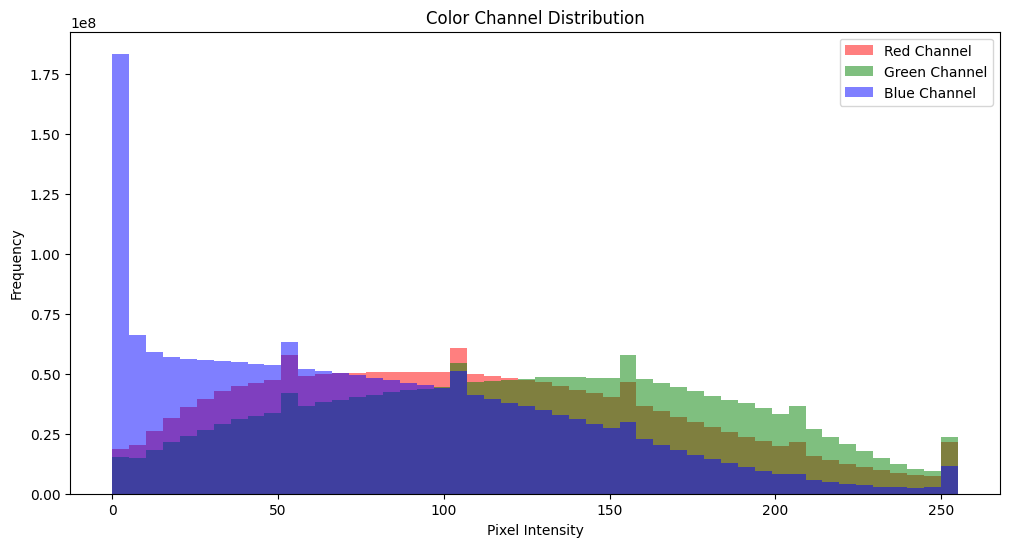

In [ ]:
n_eda_images = len(images_train)

plot_color_distribution(images_train, n_images=n_eda_images)

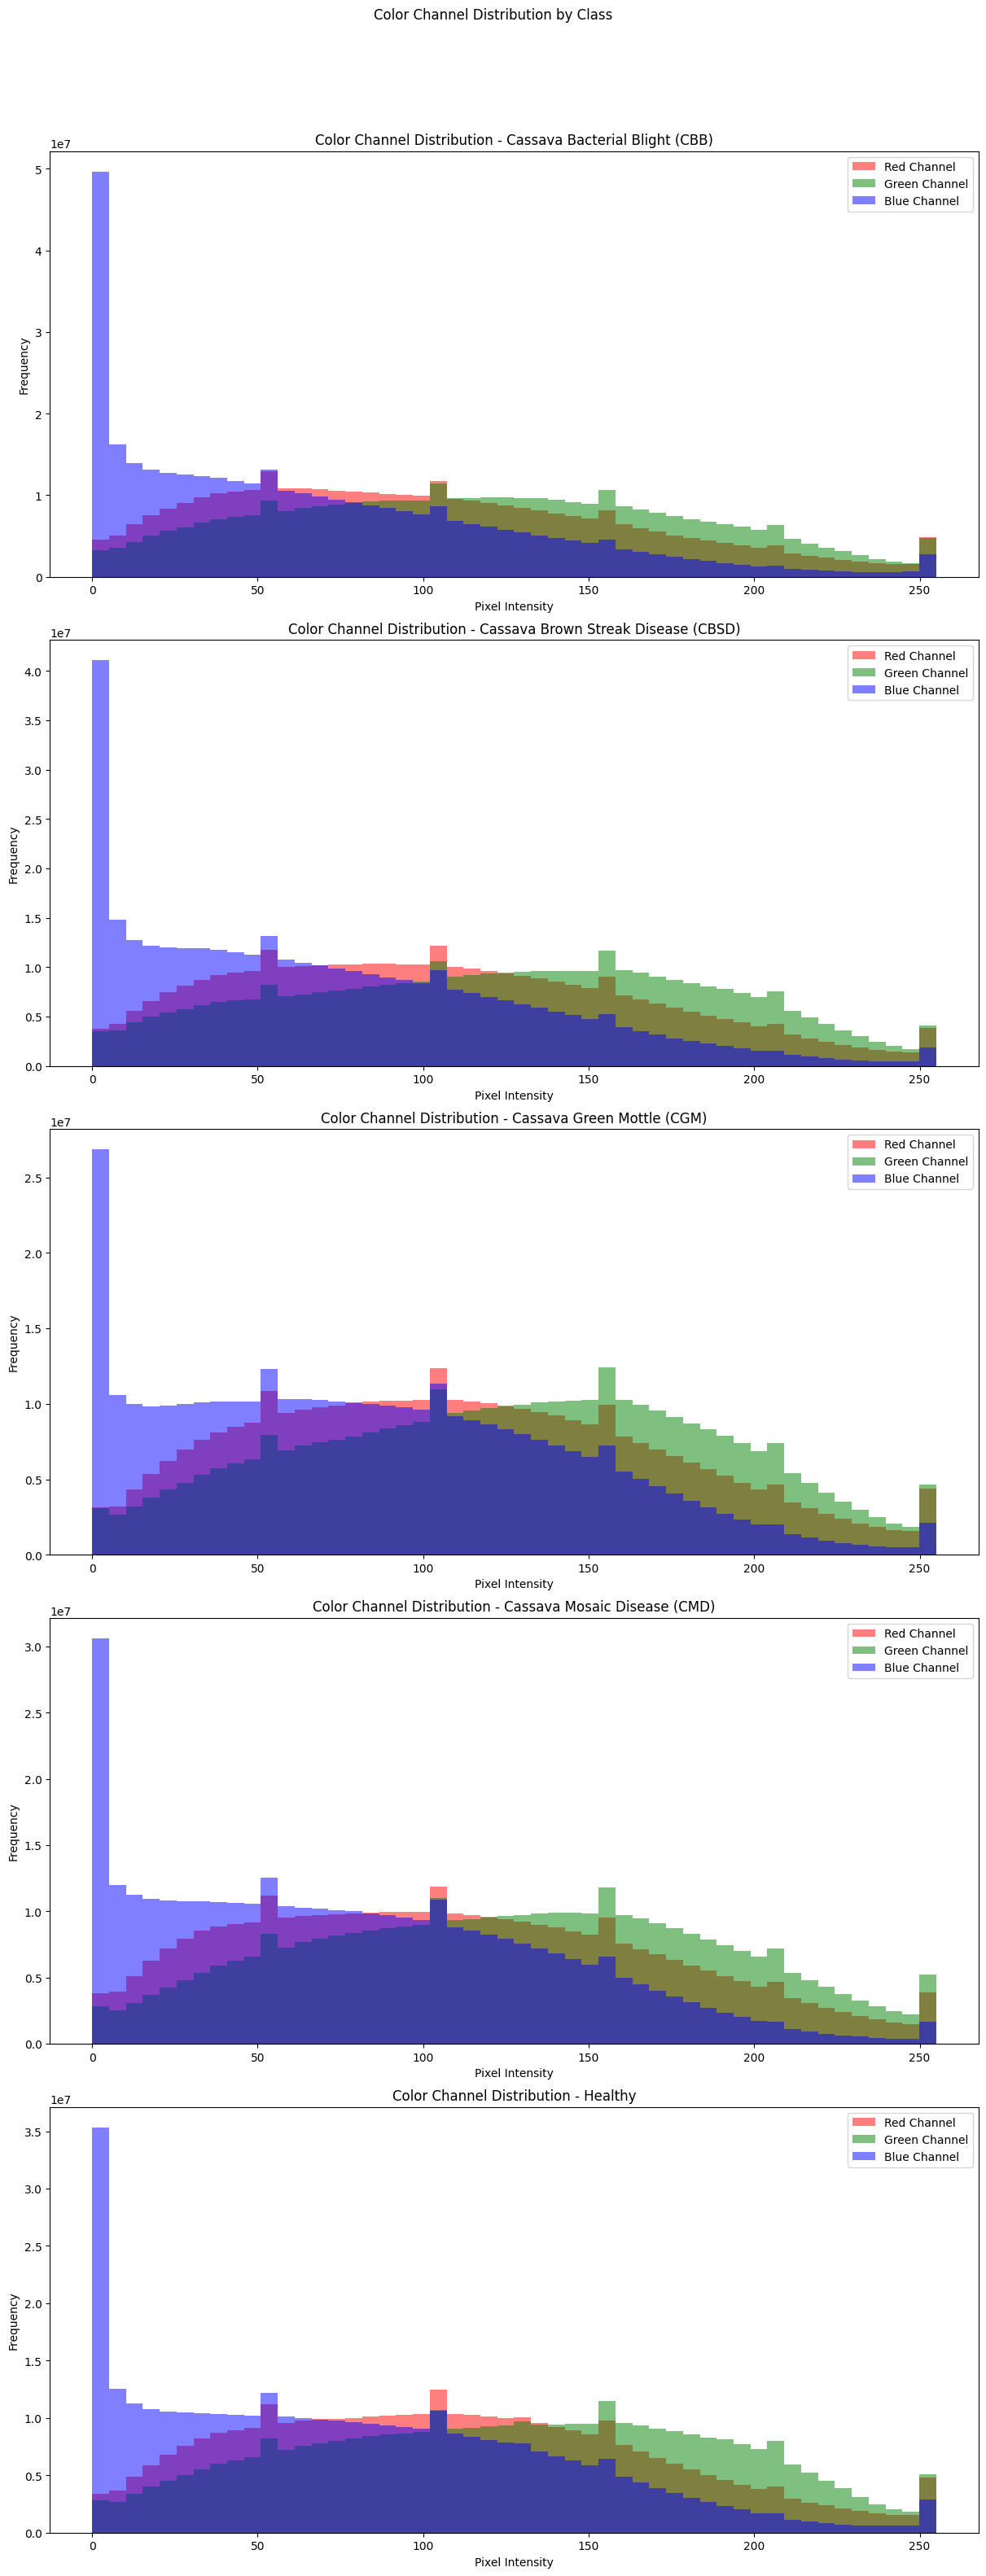

In [ ]:
def plot_color_distribution(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Plot color distributions for RGB channels across images in each class.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Organize images by class
    class_images = {label: [] for label in label_mapping.keys()}
    for img, lbl in zip(images, labels):
        class_images[lbl].append(img)

    # Plot the color distributions for each class
    fig, axs = plt.subplots(len(class_images), 1, figsize=(12, 6 * len(class_images)), constrained_layout=True)

    for i, (label, imgs) in enumerate(class_images.items()):
        all_pixels = np.vstack([img.reshape(-1, 3) for img in imgs])

        for j, color in enumerate(['Red', 'Green', 'Blue']):
            axs[i].hist(all_pixels[:, j], bins=50, color=color.lower(), alpha=0.5, label=f"{color} Channel")

        axs[i].set_title(f"Color Channel Distribution - {label_mapping[label]}")
        axs[i].set_xlabel("Pixel Intensity")
        axs[i].set_ylabel("Frequency")
        axs[i].legend()

    plt.suptitle("Color Channel Distribution by Class", y=1.05)
    plt.show()
plot_color_distribution(images_train, labels_train)

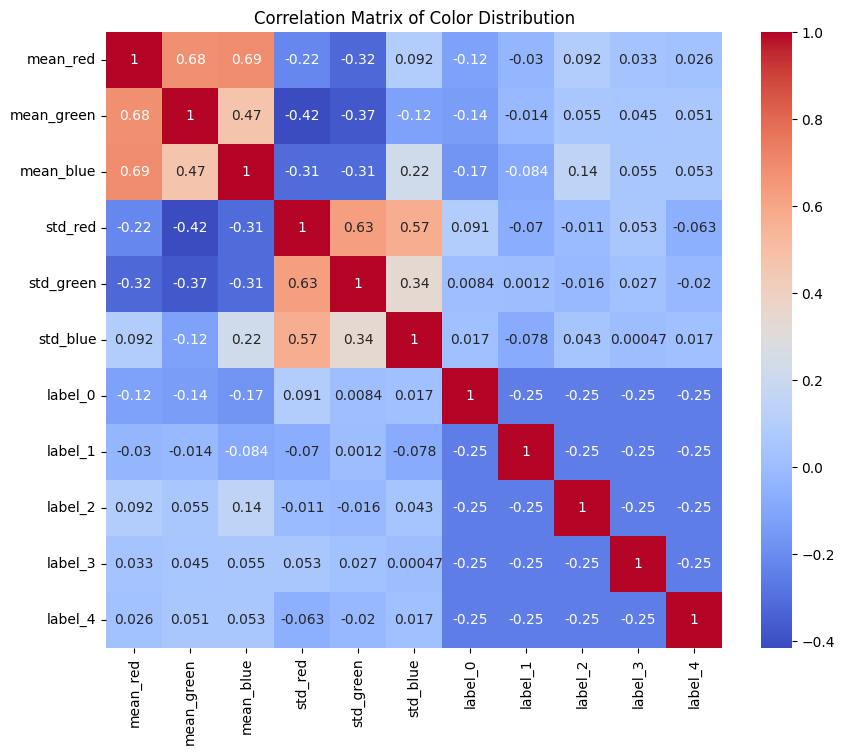

In [ ]:
one_hot_labels = pd.get_dummies(color_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([color_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Color Distribution")
plt.show()

Dominant Colors

In [ ]:
n_colors = 5   # Number of dominant colors to capture per image
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
dominant_colors_train_df = gather_dominant_colors_with_labels(images_train, labels=labels_train, n_colors=n_colors, n_images=n_images_train)
pd.DataFrame(dominant_colors_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_train_df.csv', index=False)
dominant_colors_val_df = gather_dominant_colors_with_labels(images=images_val, labels=labels_val, n_colors=n_colors, n_images=n_images_val)
pd.DataFrame(dominant_colors_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_val_df.csv', index=False)


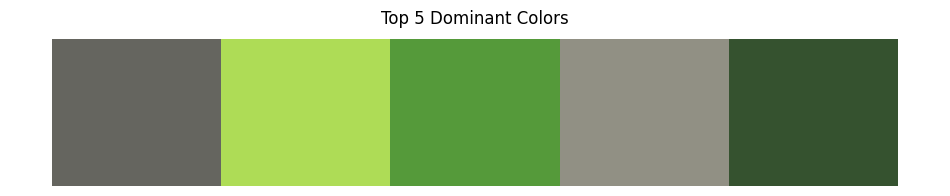

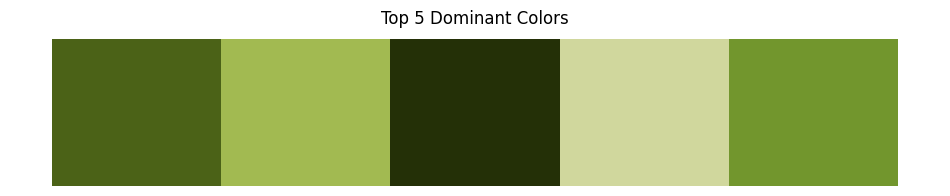

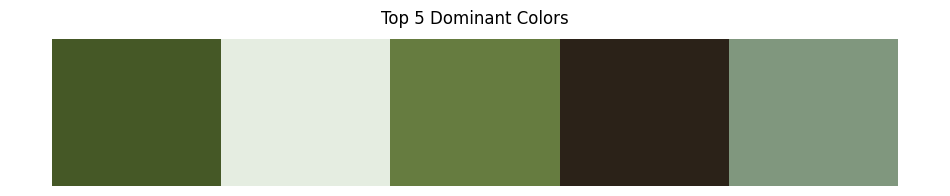

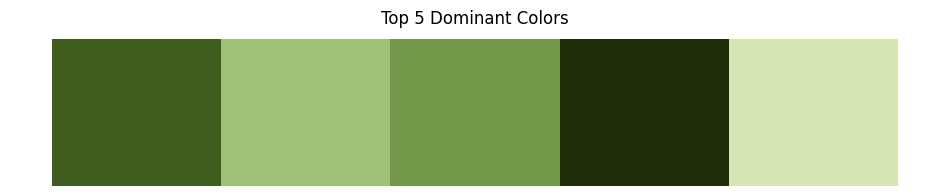

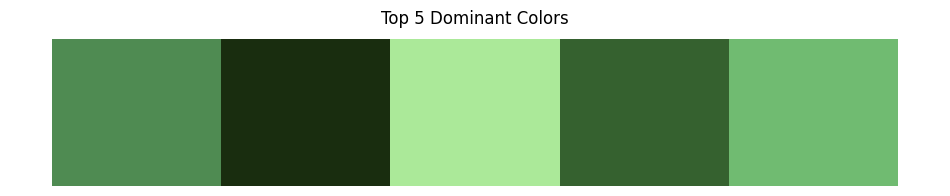

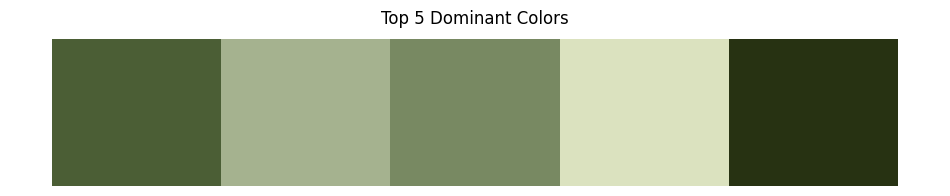

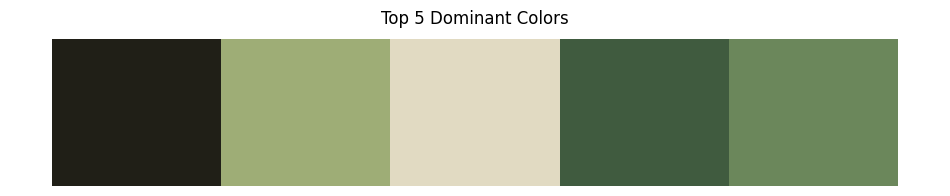

In [ ]:
# For n images, plot dominant colors
for i in range(7):
  plot_dominant_colors(images_train[i], n_colors=5)
  print('')

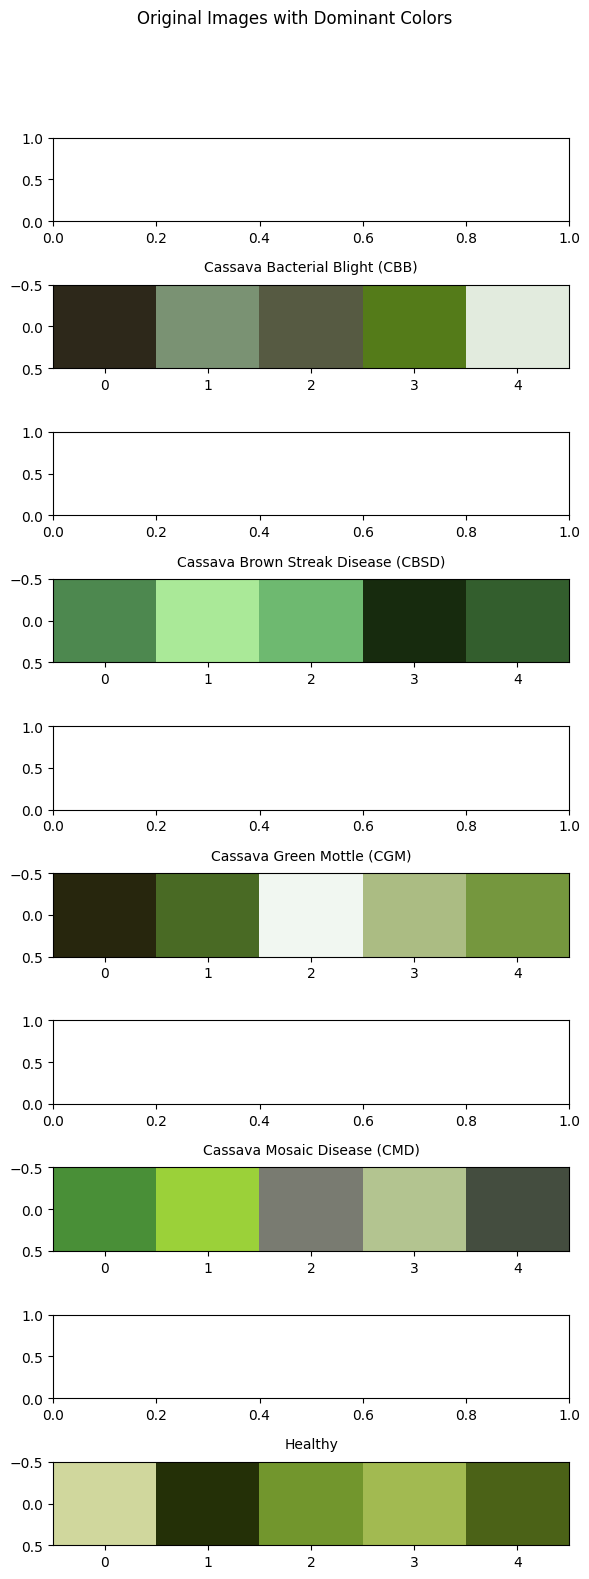

In [ ]:
def plot_dominant_colors(images: List[np.ndarray], labels: List[int], n_colors: int) -> None:
    """
    Display dominant colors for each image in a vertical arrangement using k-means clustering.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
        n_colors (int): Number of dominant colors to find.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Display the images with their dominant colors in a vertical layout
    fig, axs = plt.subplots(len(sorted_images) * 2, 1, figsize=(6, 3 * len(sorted_images)))

    for i, (img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        # Show the original image
        #axs[i * 2].imshow(img)
        #axs[i * 2].axis('off')
        #axs[i * 2].set_title(lbl, fontsize=10, pad=10)

        # Compute and show the dominant colors
        img_reshaped = img.reshape(-1, 3)
        kmeans = KMeans(n_clusters=n_colors)
        kmeans.fit(img_reshaped)
        dominant_colors = kmeans.cluster_centers_.astype(int)

        # Plot the dominant colors as bars
        color_ax = axs[i * 2 + 1]
        color_ax.imshow([dominant_colors / 255], aspect='auto')
        color_ax.set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Original Images with Dominant Colors", y=1.05)
    plt.tight_layout()
    plt.show()
plot_dominant_colors(images_train, labels_train,5)

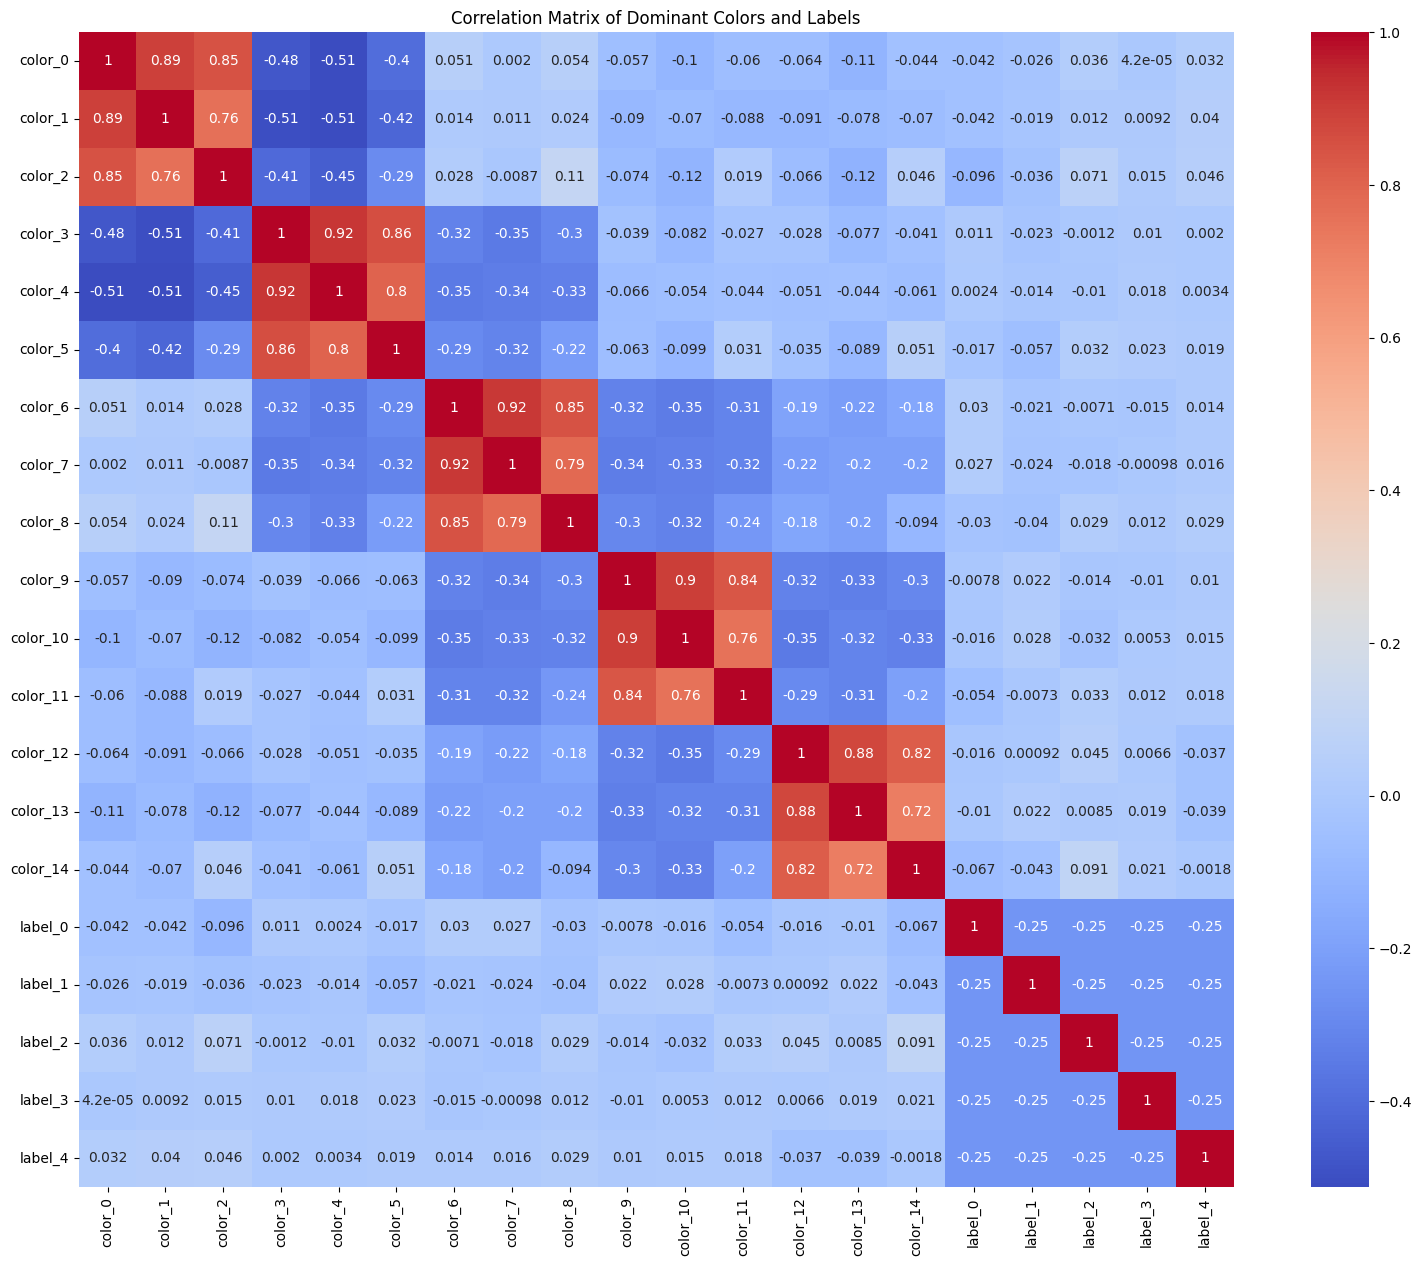

In [ ]:
one_hot_labels = pd.get_dummies(dominant_colors_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([dominant_colors_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Dominant Colors and Labels")
plt.show()

Edge Detection

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
edge_intensity_stats_train_df = gather_edge_intensity_statistics_with_labels(images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(edge_intensity_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/edge_intensity_stats_train_df.csv', index=False)
edge_intensity_stats_val_df = gather_edge_intensity_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(edge_intensity_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/edge_intensity_stats_val_df.csv', index=False)

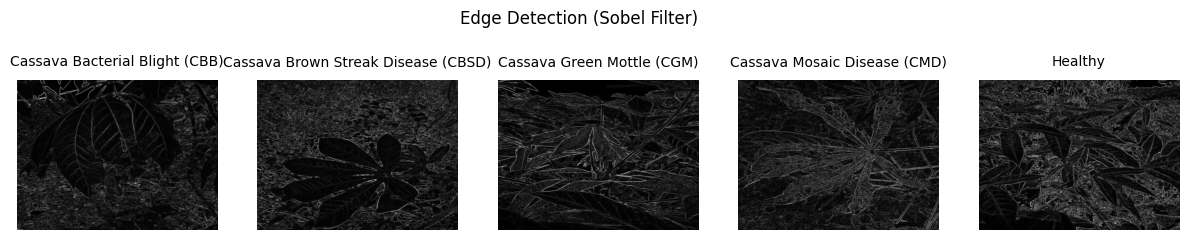

In [ ]:
plot_edge_detection(images_train,labels_train)

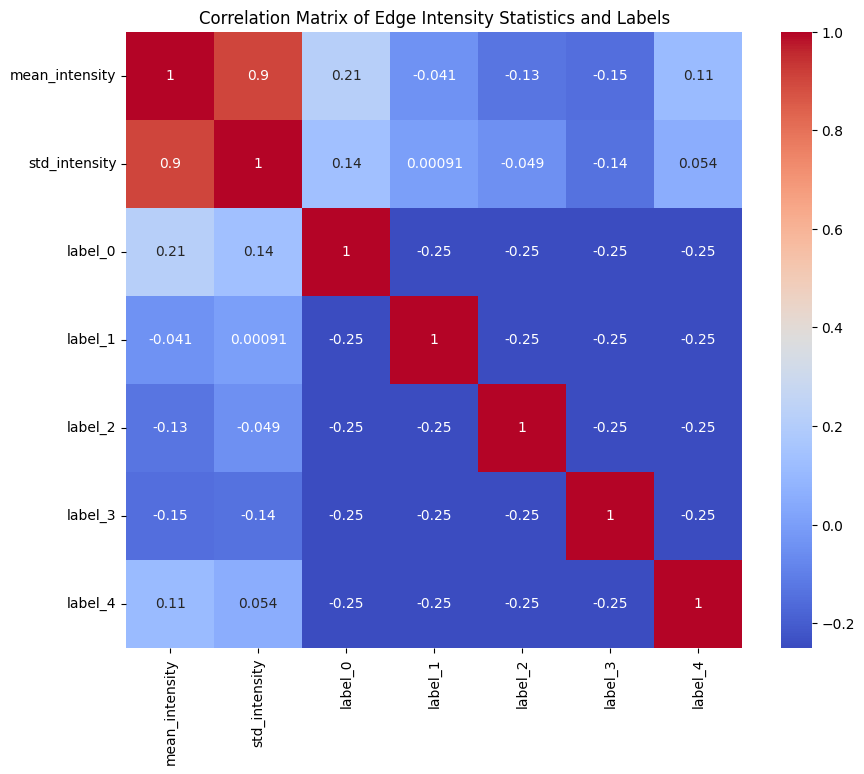

In [ ]:
edge_intensity_stats_train_df['label'] = pd.factorize(edge_intensity_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(edge_intensity_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([edge_intensity_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Edge Intensity Statistics and Labels")
plt.show()


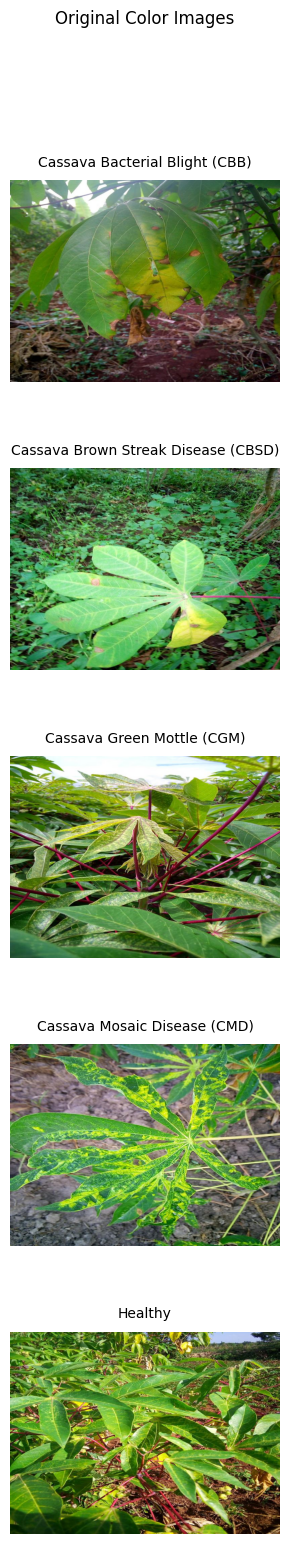

In [ ]:
def plot_original_images(images: List[np.ndarray], labels: List[int]) -> None:
    """
    Display original color images for one sample image per class type with labels, arranged vertically.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        labels (List[int]): List of numeric labels corresponding to each image.
    """
    # Dictionary to hold one image per class type
    unique_images = {}

    # Select one image for each class based on label
    for img, lbl in zip(images, labels):
        if lbl not in unique_images:
            unique_images[lbl] = img
        # Stop if we've collected one of each class type
        if len(unique_images) == len(label_mapping):
            break

    # Sort the images by label to display them in a fixed order
    sorted_labels = sorted(unique_images.keys())
    sorted_images = [unique_images[label] for label in sorted_labels]
    sorted_labels = [label_mapping[label] for label in sorted_labels]

    # Display the original color images in a vertical layout
    fig, axs = plt.subplots(len(sorted_images), 1, figsize=(3, 3 * len(sorted_images)))

    for i, (img, lbl) in enumerate(zip(sorted_images, sorted_labels)):
        axs[i].imshow(img)  # Display the original color image
        axs[i].axis('off')
        axs[i].set_title(lbl, fontsize=10, pad=10)

    plt.suptitle("Original Color Images", y=1.05)
    plt.tight_layout()
    plt.show()

plot_original_images(images_train,labels_train)

Edge Orientation Statistics

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
orientation_stats_train_df = gather_edge_orientation_statistics_with_labels(images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(orientation_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/orientation_stats_train_df.csv', index=False)
orientation_stats_val_df = gather_edge_orientation_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(orientation_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/orientation_stats_val_df.csv', index=False)

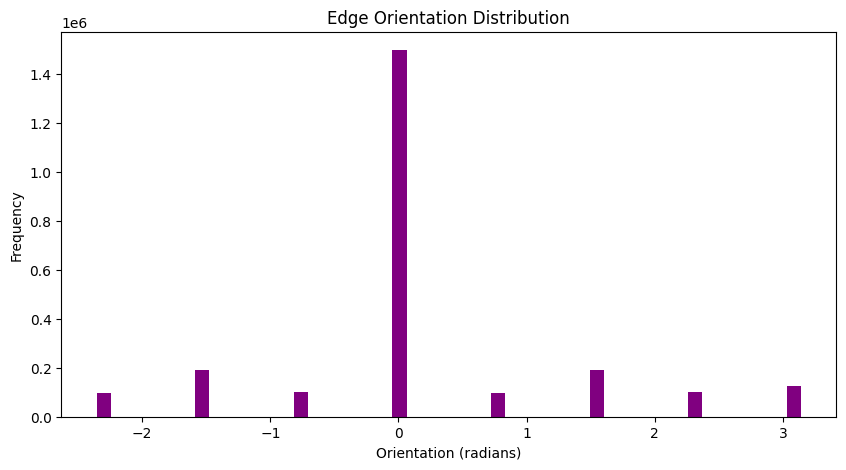

In [ ]:
plot_edge_orientation_distribution(images_train, n_images=5)

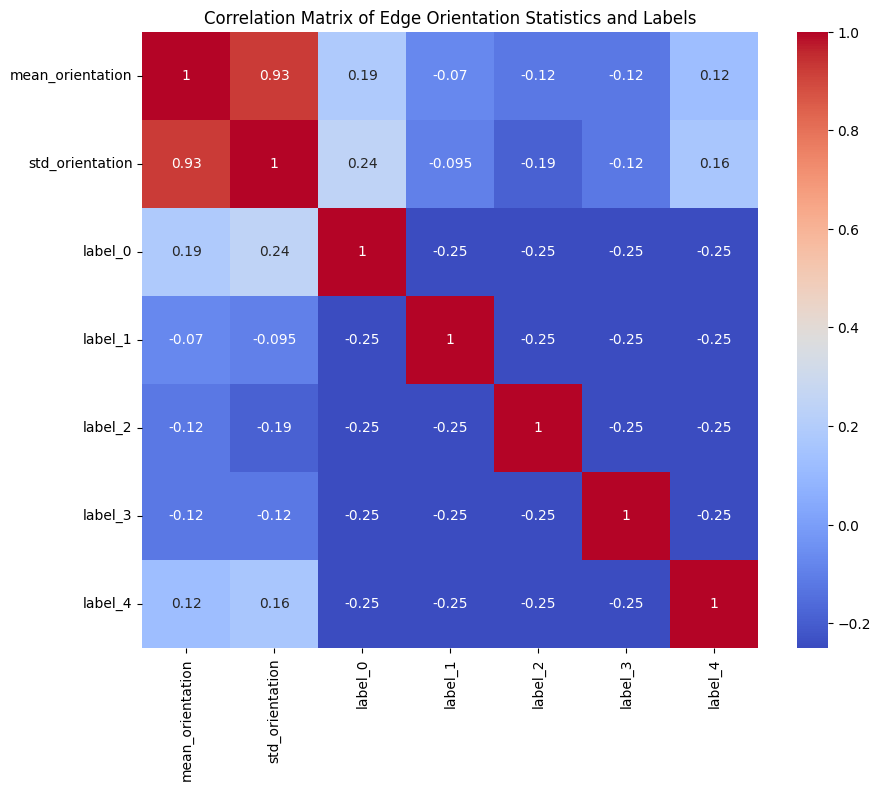

In [ ]:
orientation_stats_train_df['label'] = pd.factorize(orientation_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(orientation_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([orientation_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Edge Orientation Statistics and Labels")
plt.show()

Hog Analysis

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
hog_stats_train_df = gather_hog_statistics_with_labels(images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(hog_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/hog_stats_train_df.csv', index=False)
hog_stats_val_df = gather_hog_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(hog_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/hog_stats_val_df.csv', index=False)


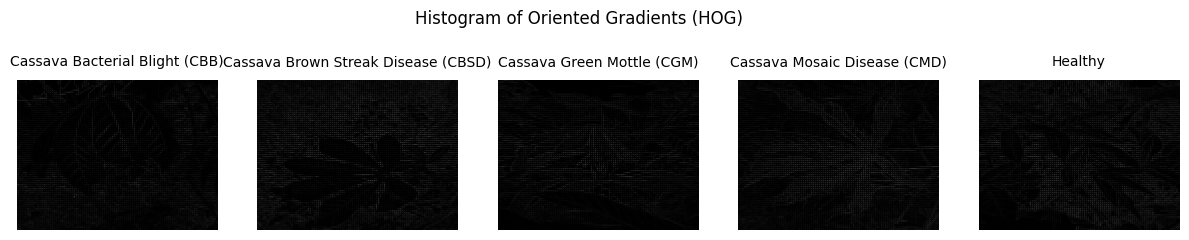

In [ ]:
plot_hog_analysis(images_train,labels_train)

<function matplotlib.pyplot.show(close=None, block=None)>

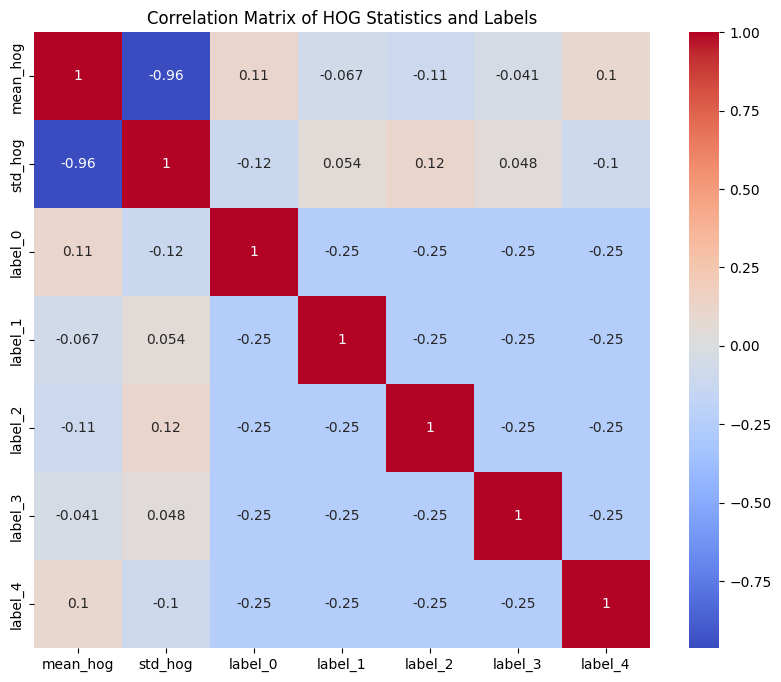

In [ ]:
hog_stats_train_df['label'] = pd.factorize(hog_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(hog_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([hog_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of HOG Statistics and Labels")
plt.show

Frequency Analysis

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
frequency_stats_train_df = gather_frequency_statistics_with_labels(images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(frequency_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/frequency_stats_train_df.csv', index=False)

n_images_val = len(images_val)
frequency_stats_val_df = gather_frequency_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(frequency_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/frequency_stats_val_df.csv', index=False)


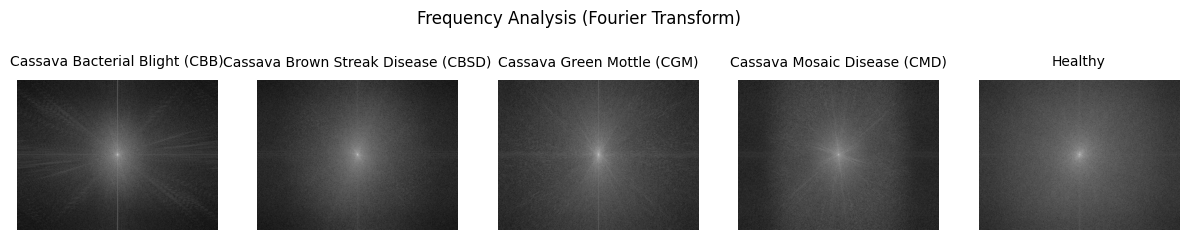

In [ ]:
plot_frequency_analysis(images_train,labels_train)

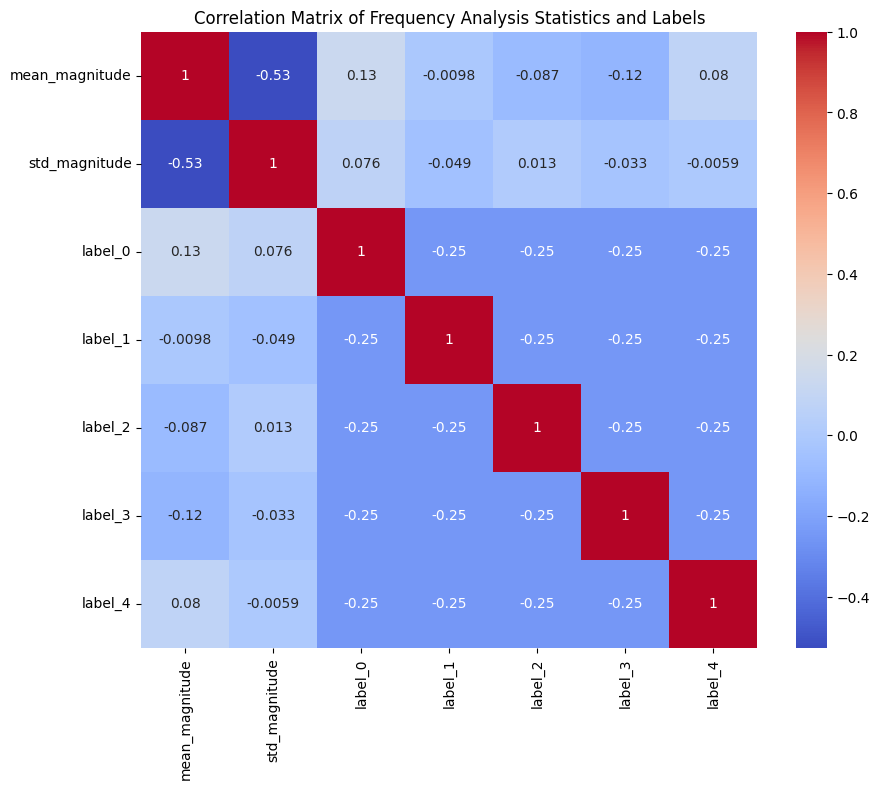

In [ ]:
frequency_stats_train_df['label'] = pd.factorize(frequency_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(frequency_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([frequency_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Frequency Analysis Statistics and Labels")
plt.show()


Dimensionality Reduction

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to processs
pca_stats_train_df = gather_pca_components_with_labels(images=images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(pca_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/pca_stats_train_df.csv', index=False)
pca_stats_val_df = gather_pca_components_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(pca_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/pca_stats_val_df.csv', index=False)


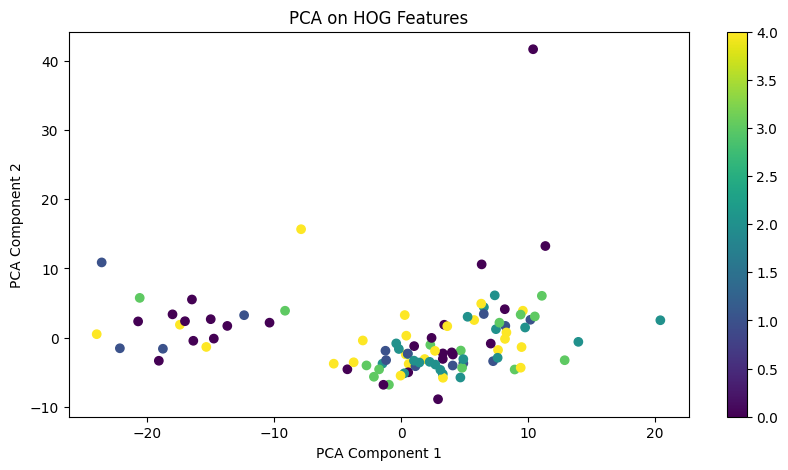

In [ ]:
plot_dimensionality_reduction(images_train, labels_train, n_images=100)

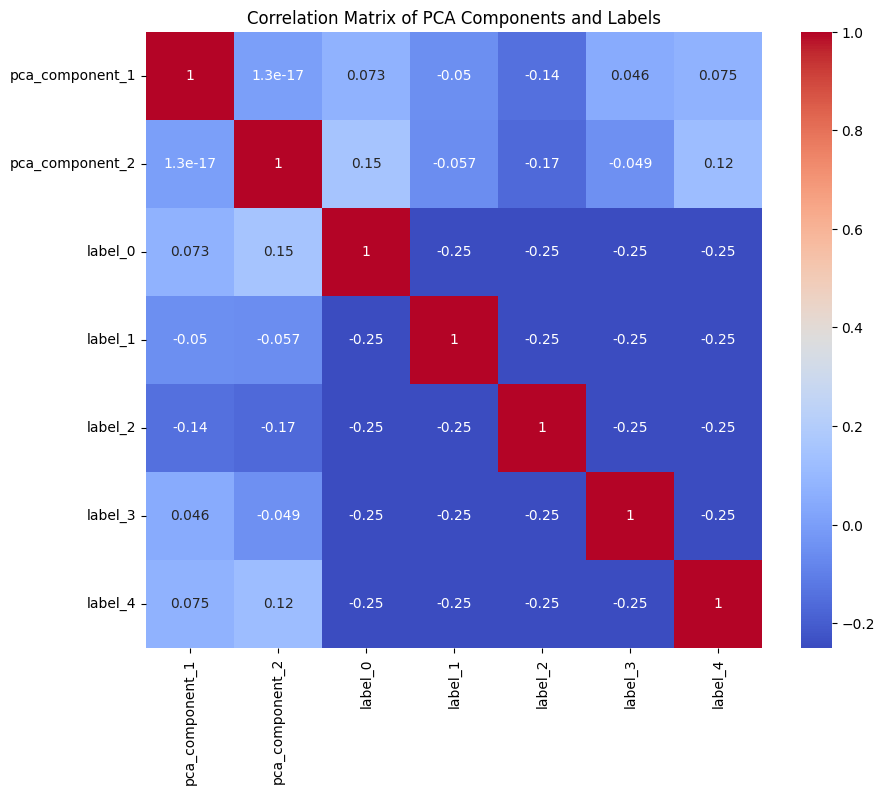

In [ ]:
pca_stats_train_df['label'] = pd.factorize(pca_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(pca_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([pca_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of PCA Components and Labels")
plt.show()


Outlier Detection

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to process
intensity_stats_train_df = gather_intensity_statistics_with_labels(images=images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(intensity_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/intensity_stats_train_df.csv', index=False)
intensity_stats_val_df = gather_intensity_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(intensity_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/intensity_stats_val_df.csv', index=False)


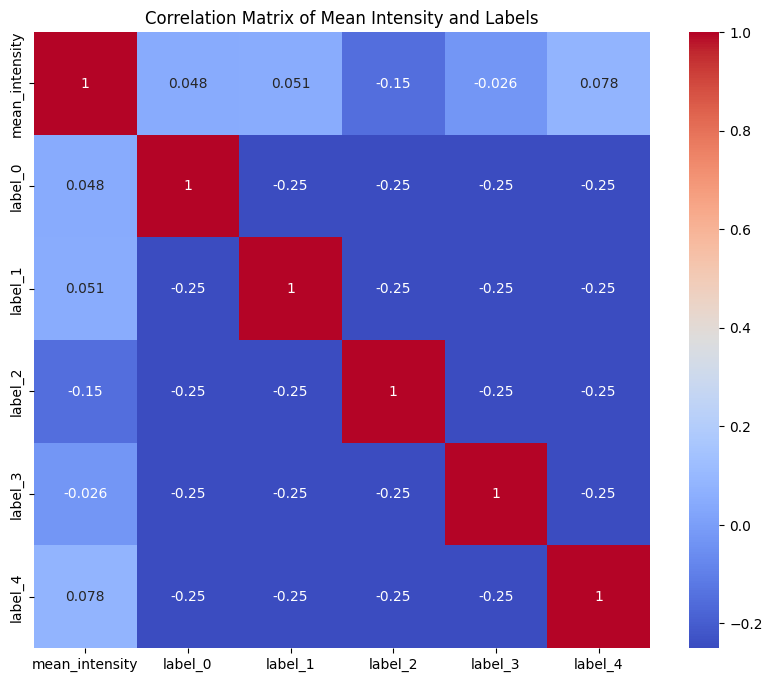

In [ ]:
intensity_stats_train_df['label'] = pd.factorize(intensity_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(intensity_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([intensity_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Mean Intensity and Labels")
plt.show()

Texture Features

In [ ]:
n_images_train = len(images_train)  # Number of images to process
n_images_val = len(images_val)  # Number of images to process
lbp_stats_train_df = gather_lbp_statistics_with_labels(images=images_train, labels=labels_train, n_images=n_images_train)
pd.DataFrame(lbp_stats_train_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/lbp_stats_train_df.csv', index=False)
lbp_stats_val_df = gather_lbp_statistics_with_labels(images=images_val, labels=labels_val, n_images=n_images_val)
pd.DataFrame(lbp_stats_val_df).to_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/lbp_stats_val_df.csv', index=False)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


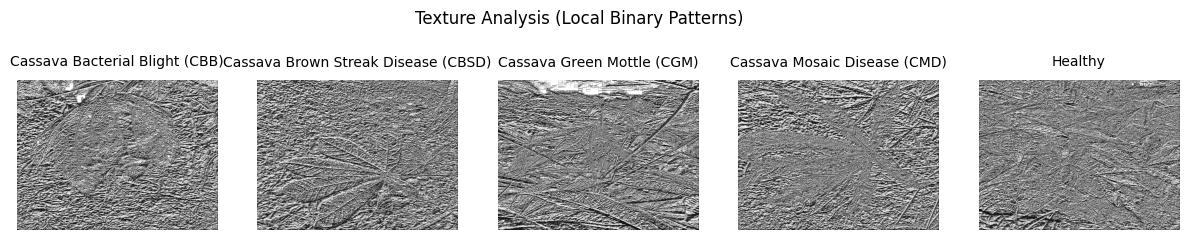

In [ ]:
plot_texture_analysis(images_train,labels_train)

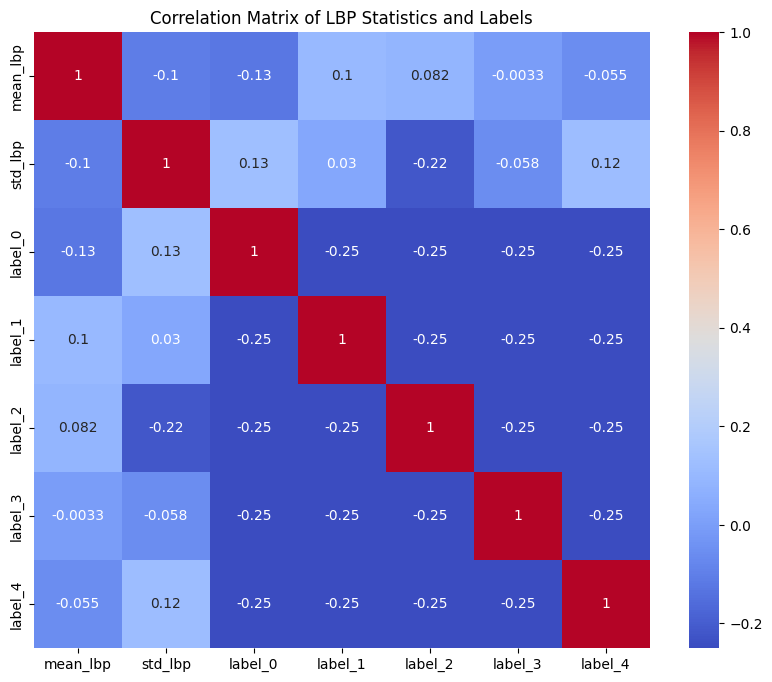

In [ ]:
lbp_stats_train_df['label'] = pd.factorize(lbp_stats_train_df['label'])[0]
one_hot_labels = pd.get_dummies(lbp_stats_train_df['label'], prefix='label')
data_with_one_hot = pd.concat([lbp_stats_train_df.drop('label', axis=1), one_hot_labels], axis=1)

correlation_matrix = data_with_one_hot.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of LBP Statistics and Labels")
plt.show()

In [ ]:
color_stats_train_df  = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/color_stats_train_df.csv')
dominant_colors_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_train_df.csv')
edge_intensity_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/edge_intensity_stats_train_df.csv')
frequency_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/frequency_stats_train_df.csv')
intensity_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/intensity_stats_train_df.csv')
pca_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/pca_stats_train_df.csv')
hog_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/hog_stats_train_df.csv')
dominant_colors_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_train_df.csv')
orientation_stats_train_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/orientation_stats_train_df.csv')

In [ ]:
color_stats_val_df  = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/color_stats_val_df.csv')
dominant_colors_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_val_df.csv')
edge_intensity_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/edge_intensity_stats_val_df.csv')
frequency_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/frequency_stats_val_df.csv')
intensity_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/intensity_stats_val_df.csv')
pca_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/pca_stats_val_df.csv')
hog_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/hog_stats_val_df.csv')
dominant_colors_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/dominant_colors_val_df.csv')
orientation_stats_val_df = pd.read_csv('/content/drive/MyDrive/DATASCI 281/DATASCI 281 Final Project/Data/features/orientation_stats_val_df.csv')

Random Forest Model

In [ ]:
import pandas as pd

# Concatenate all feature DataFrames along the columns
features_train_df = pd.concat([color_stats_train_df.drop('label', axis=1), dominant_colors_train_df.drop('label', axis=1), edge_intensity_stats_train_df.drop('label', axis=1), frequency_stats_train_df.drop('label', axis=1), intensity_stats_train_df.drop('label', axis=1), pca_stats_train_df.drop('label', axis=1), hog_stats_train_df.drop('label', axis=1), dominant_colors_train_df.drop('label', axis=1), orientation_stats_train_df], axis=1)

X_train = features_train_df.drop('label', axis=1)
y_train = features_train_df['label']


In [ ]:
features_val_df = pd.concat([color_stats_val_df.drop('label', axis=1), dominant_colors_val_df.drop('label', axis=1), edge_intensity_stats_val_df.drop('label', axis=1), frequency_stats_val_df.drop('label', axis=1), intensity_stats_val_df.drop('label', axis=1), pca_stats_val_df.drop('label', axis=1), hog_stats_val_df.drop('label', axis=1), dominant_colors_val_df.drop('label', axis=1), orientation_stats_val_df], axis=1)

X_val = features_val_df.drop('label', axis=1)
y_val = features_val_df['label']

In [ ]:
X_train.shape

(3684, 47)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Set up Random Forest with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 450],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 15]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)  # 5-fold cross-validation

# Fit with cross-validation
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 30],
                         'min_samples_split': [2, 5, 15],
                         'n_estimators': [100, 200, 450]})

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_val)
# Calculate the overall accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Overall Model Accuracy: {accuracy * 100:.2f}%")

# Generate and display the classification report
report = classification_report(y_val, y_pred, target_names=['Cassava Bacterial Blight (CBB) - 0', 'Cassava Brown Streak Disease (CBSD) - 1', 'Cassava Green Mottle (CGM) - 2', 'Cassava Mosaic Disease (CMD) - 3', 'Healthy - 4'])
print("Accuracy per label (Recall):")
print(report)

Overall Model Accuracy: 38.04%
Accuracy per label (Recall):
                                         precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB) - 0       0.41      0.55      0.47        92
Cassava Brown Streak Disease (CBSD) - 1       0.29      0.22      0.25        92
         Cassava Green Mottle (CGM) - 2       0.34      0.37      0.36        92
       Cassava Mosaic Disease (CMD) - 3       0.43      0.50      0.46        92
                            Healthy - 4       0.38      0.26      0.31        92

                               accuracy                           0.38       460
                              macro avg       0.37      0.38      0.37       460
                           weighted avg       0.37      0.38      0.37       460



In [ ]:
label_mapping = {
    'Cassava Bacterial Blight (CBB)': 0,
    'Cassava Green Mottle (CGM)': 2,
    'Healthy': 4,
    'Cassava Mosaic Disease (CMD)': 3,
    'Cassava Brown Streak Disease (CBSD)': 1
}

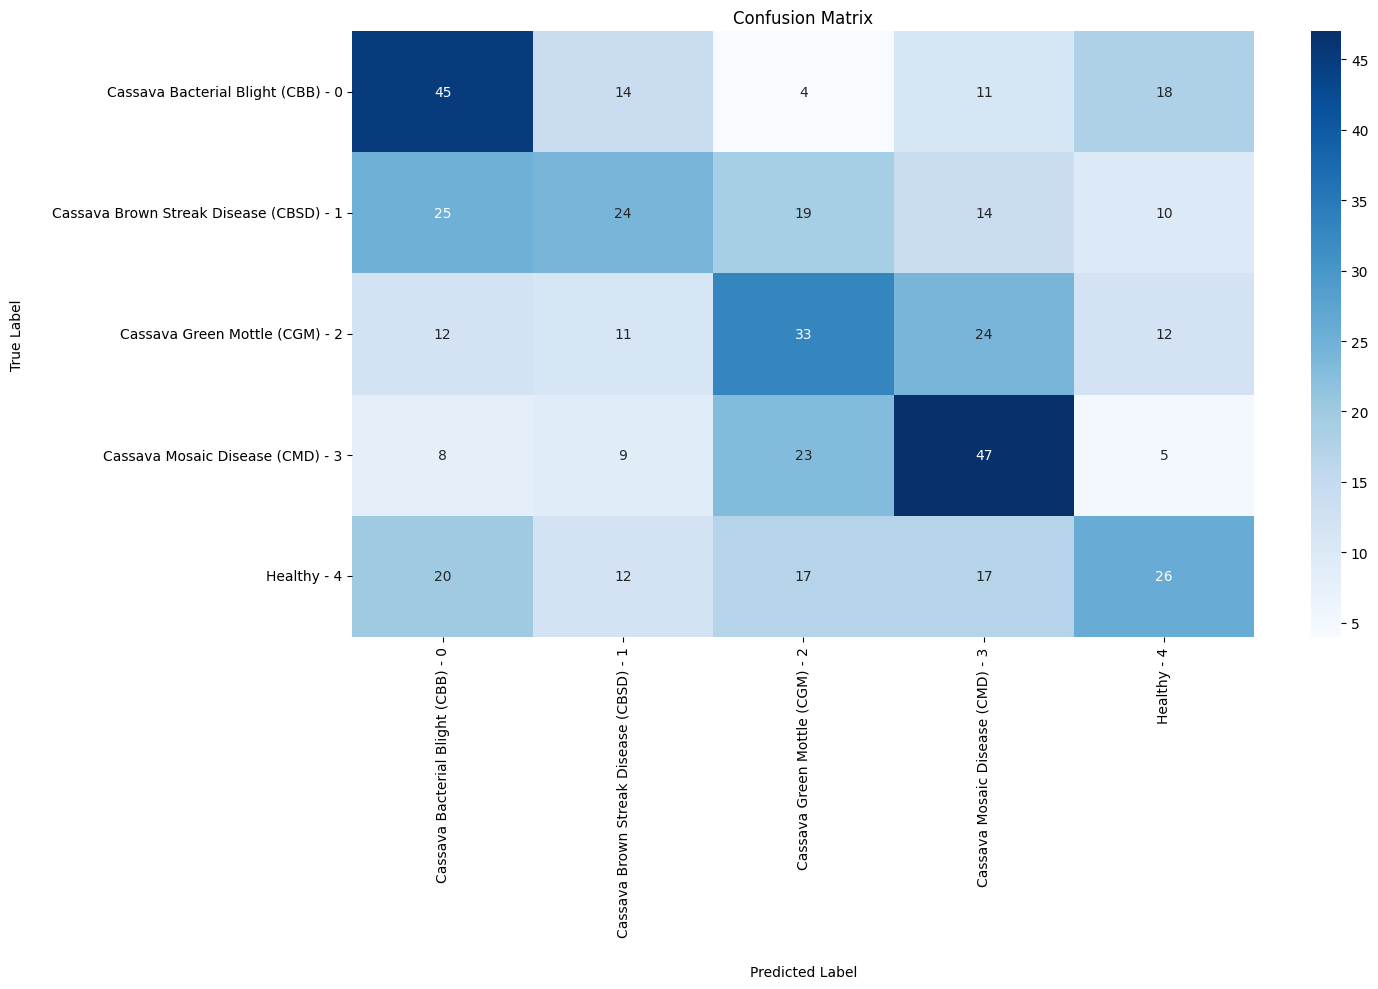

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cassava Bacterial Blight (CBB) - 0', 'Cassava Brown Streak Disease (CBSD) - 1', 'Cassava Green Mottle (CGM) - 2', 'Cassava Mosaic Disease (CMD) - 3', 'Healthy - 4'], yticklabels=['Cassava Bacterial Blight (CBB) - 0', 'Cassava Brown Streak Disease (CBSD) - 1', 'Cassava Green Mottle (CGM) - 2', 'Cassava Mosaic Disease (CMD) - 3', 'Healthy - 4'])

# Increase space between axis labels and titles
plt.xlabel('Predicted Label', labelpad=20)  # Adjust labelpad as needed
plt.ylabel('True Label', labelpad=20)       # Adjust labelpad as needed
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.tight_layout()  # Ensure everything fits well within the figure
plt.show()